In [2175]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [2176]:
file  = "HSt42_10/RH80_PR10_1000day_startfrom_0day_final.dat"
ds = h5py.File(file, "r")
print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [2177]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [2178]:
def read_all_var(pr, start, end, internal_day, total_file):
    qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))
    a = 0
    for day in range(start,end,internal_day):
        # print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        ps_all[a,:,:,:,:]    = dycore.ps
        
        p_half_all[a,:,:,:,:]    = dycore.p_half
        a += 1
        # print(a)
    # qv_all_new      = np.nanmean(qv_all  , axis=0)
    # qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    # u_new      = np.nanmean(u_all  , axis=0)
    # v_new      = np.nanmean(v_all  , axis=0)
    # t_new      = np.nanmean(t_all  , axis=0)
    # p_new      = np.nanmean(p_all  , axis=0)
    # p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    # qv = qv_all
    # qv_diff = qv_diff_new
    # u = u_new
    # v = v_new
    # t = t_new
    # p = p_new
    # p_half = p_half_new
    return qv_all, qv_diff_all, u_all, v_all, t_all, p_all, ps_all, p_half_all

In [2179]:
def cal_pre(qv_diff, p_half):
    g = 9.81
    Prec = np.zeros(qv_diff.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean2 = np.nanmean(Prec_mean, axis=(2))
    
    return Prec_mean2

In [2180]:
def cal_KE(u, v):
    KE = (u**2 + v**2)
    KE_mean = np.nanmean(KE, axis=(1,3))
    return KE_mean

1000


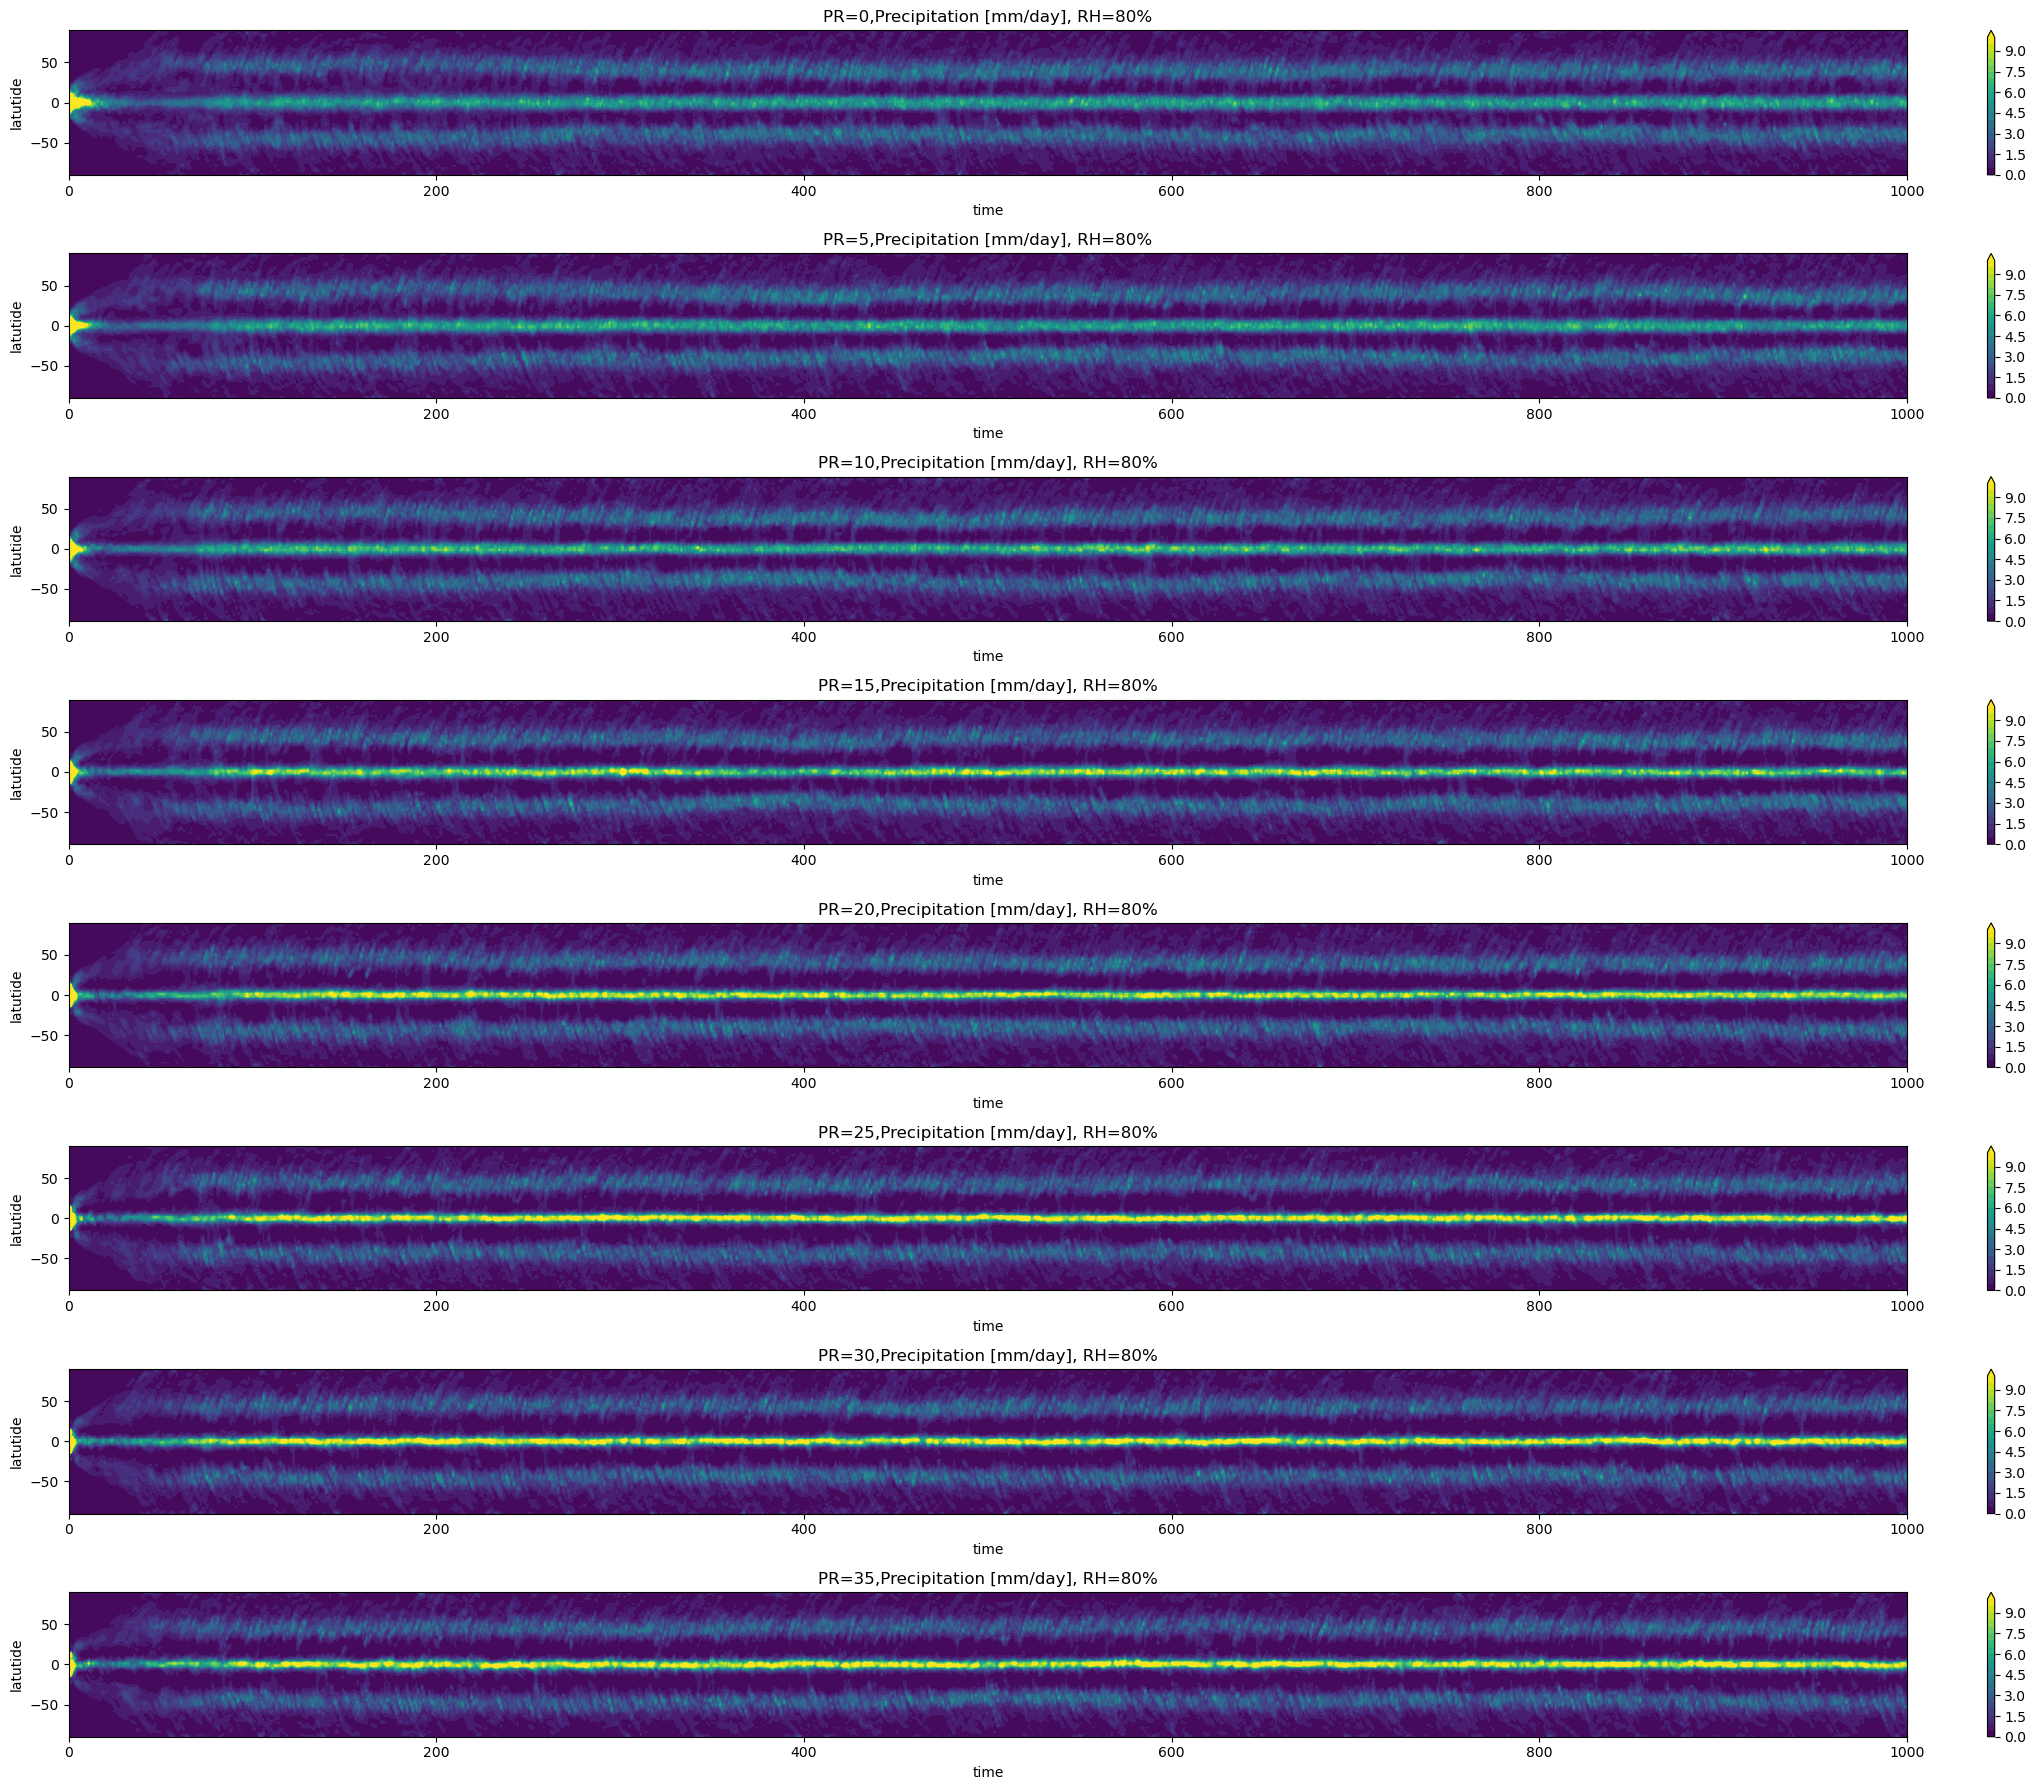

In [2181]:
pr_start = 0
pr_leap = 5
pr_to = 40
nProc = 2

start = 0
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = True
do_check_KE = False
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                # u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                # v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                # t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]        = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:] = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                # u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                # v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                # t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                
                

    if do_check_qv:
        Prec_new   = cal_pre(qv_diff, p_half)
        CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
        ax[a].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_KE:
        get_KE = cal_KE(u, v)   
        CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(60,1200,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_t:
        t_mean = np.nanmean(t[:,:,:,:], axis=(1,3))
        CS = ax[a].contourf(tt, yy, t_mean,levels=21, extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Temperature [K], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
        
        
if do_check_qv:
    fig.tight_layout()
    # plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_KE:
    fig.tight_layout()
    # plt.savefig("check_KE_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_t:
    fig.tight_layout()
    # plt.savefig("check_T_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

    #     print(result.shape)
    #     print(result)
    # EMF_80[a,:] = EMF_results[32:]
    # EQF_80[a,:] = EQF_results[32:]
    # EHF_80[a,:] = EHF_results[32:]
    # EKF_80[a,:] = EKF_results[32:]
    # prec_80[a,:]  = prec_results[:] #* float(t)

# Calculate EOF of u, then plot y-z 

In [2182]:
from EOF import EOF

In [2183]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)
# cy [0] = np.nan
# cy [-1] = np.nan
cy

array([6.12323400e-17, 4.98458857e-02, 9.95678466e-02, 1.49042266e-01,
       1.98146143e-01, 2.46757398e-01, 2.94755174e-01, 3.42020143e-01,
       3.88434796e-01, 4.33883739e-01, 4.78253979e-01, 5.21435203e-01,
       5.63320058e-01, 6.03804410e-01, 6.42787610e-01, 6.80172738e-01,
       7.15866849e-01, 7.49781203e-01, 7.81831482e-01, 8.11938006e-01,
       8.40025923e-01, 8.66025404e-01, 8.89871809e-01, 9.11505852e-01,
       9.30873749e-01, 9.47927346e-01, 9.62624247e-01, 9.74927912e-01,
       9.84807753e-01, 9.92239207e-01, 9.97203797e-01, 9.99689182e-01,
       9.99689182e-01, 9.97203797e-01, 9.92239207e-01, 9.84807753e-01,
       9.74927912e-01, 9.62624247e-01, 9.47927346e-01, 9.30873749e-01,
       9.11505852e-01, 8.89871809e-01, 8.66025404e-01, 8.40025923e-01,
       8.11938006e-01, 7.81831482e-01, 7.49781203e-01, 7.15866849e-01,
       6.80172738e-01, 6.42787610e-01, 6.03804410e-01, 5.63320058e-01,
       5.21435203e-01, 4.78253979e-01, 4.33883739e-01, 3.88434796e-01,
      

8
(800, 1280)
(800, 1280)
(800, 1280)
(800, 1280)
(800, 1280)
(800, 1280)
(800, 1280)
(800, 1280)


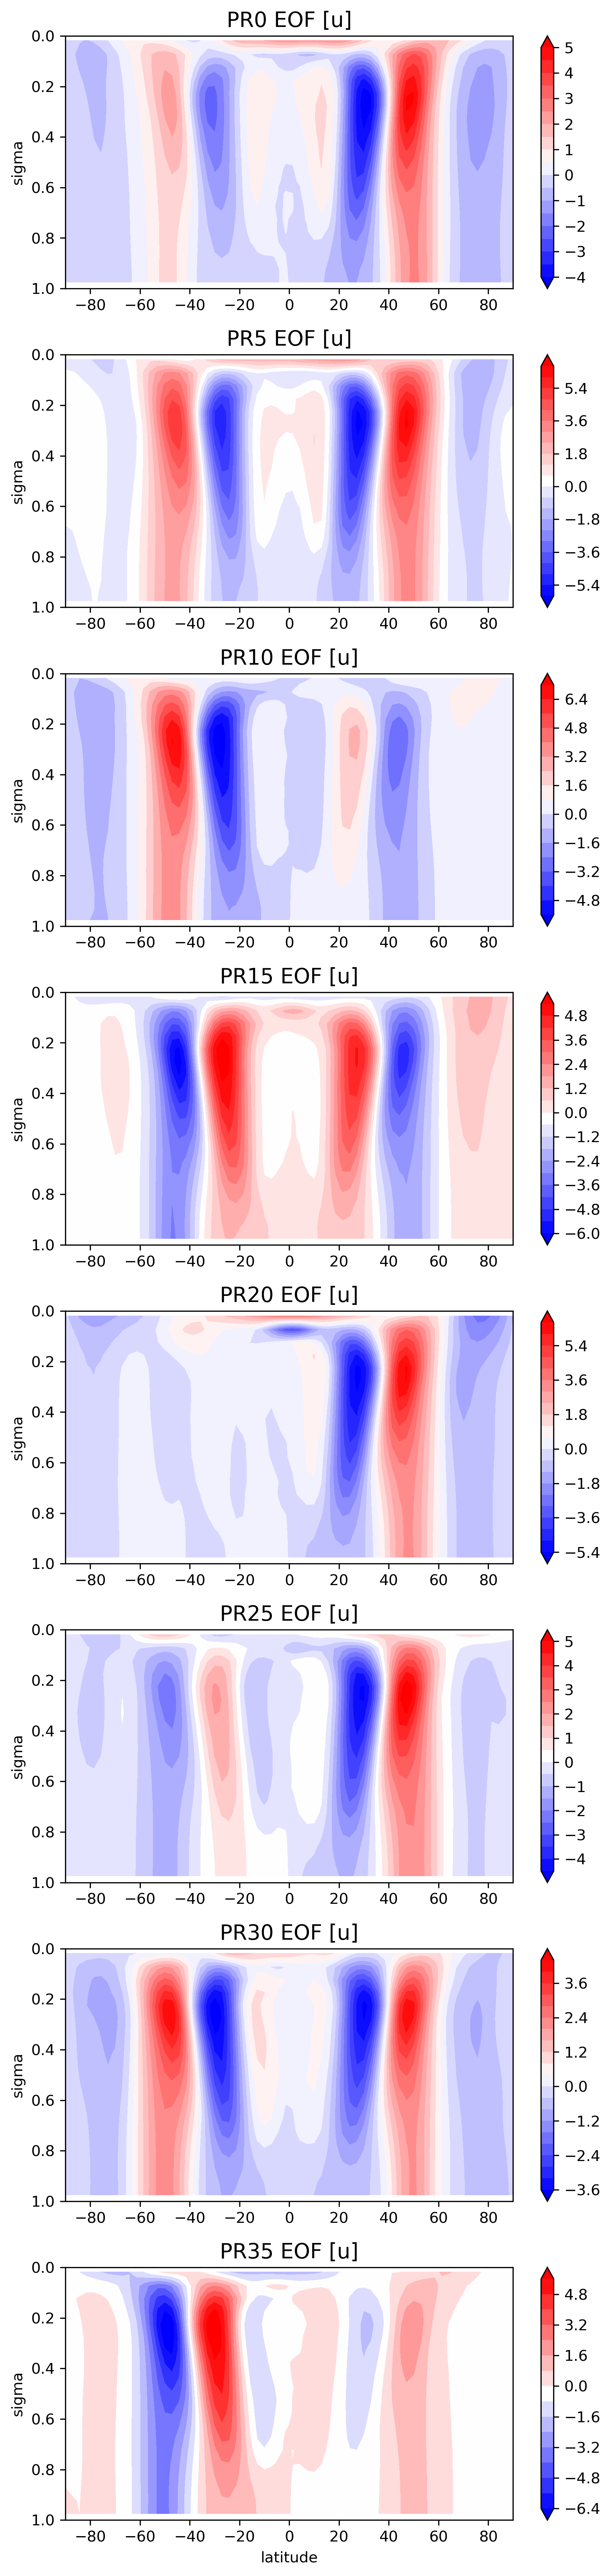

In [2184]:
pr_start = 0
pr_leap = 5
pr_to = 40
nProc = 2


### fig
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,24), dpi=300.)
print(int((pr_to - pr_start)/pr_leap))
#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal)
# print(total_file)
total_day = int(total_file*internal_day)


u = np.zeros((((total_day, 20, 64, 128))))


do_check_u_EOF = True
check_days_length = int(800)

sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u_EOF:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
          
            else:
                u[k*100:(k+1)*100,:,:,:]   = u_ini[k,:,:,:,:]

    # Step 1: weight and time, zonal mean
    u_w = np.zeros((((check_days_length, 20, 64, 128))))
    for i in range(0,64):
        u_w[:,:,i,:] = u[-check_days_length:,:,i,:] #* (cy[i])**0.5
    u_w_zy = np.nanmean(u_w[:,:,:,:], axis=(3))
    u_w_zy_reshape = np.reshape(u_w_zy, (check_days_length, 20*64))
    print(u_w_zy_reshape.shape)
    # Step 2: do EOF of u
    single_EOF = EOF((u_w_zy_reshape,), n_components=check_days_length, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs   = single_EOF.PC[0,:]
    EOFs  = single_EOF.EOF[0,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy = np.reshape(EOFs, (20,64))

    # Step 5: plot
    CS = ax[a].contourf(yy, sigma_mean2, EOFs_zy, levels=21, cmap="bwr", extend="both")
    fig.colorbar(CS, ax=ax[a], extend="both")
    ax[a].set_ylim([1,0])
    ax[a].set_title(f"PR{pr} EOF [u]", fontsize=14)
    ax[a].set_ylabel("sigma")
    ax[-1].set_xlabel("latitude")
    a += 1
fig.tight_layout()
plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()
    # if do_check_u_EOF:
    #     Prec_new   = cal_pre(qv_diff, p_half)
    #     CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
    #     fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
    #     ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
    #     ax[a].set_xlabel("time")
    #     ax[a].set_ylabel("latutide")
    #     a += 1

Text(0.5, 0, 'Day')

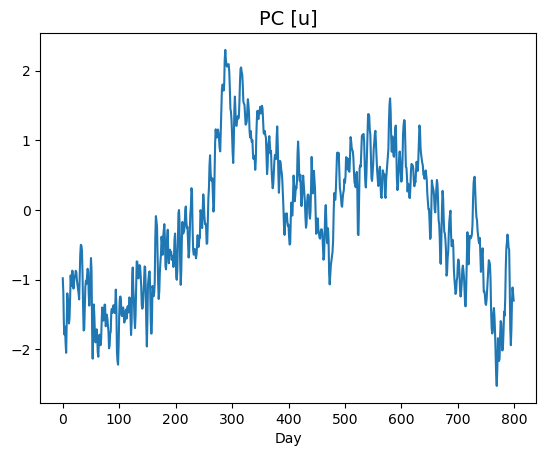

In [2185]:
plt.figure()
plt.plot(PCs)
# plt.ylim([1,0])
plt.title("PC [u]", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

Text(0.5, 0, 'Day')

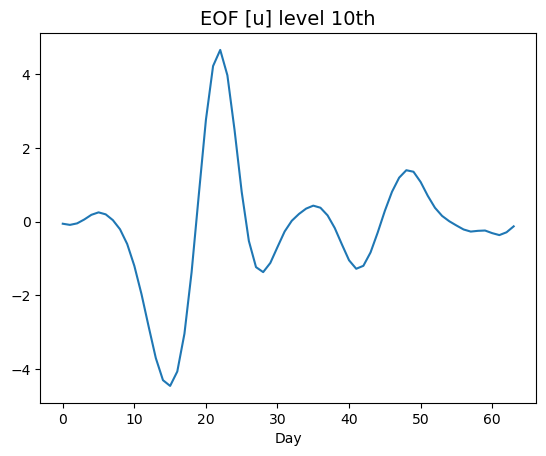

In [2186]:
plt.figure()
EOFs_final = np.reshape(EOFs, (20,64))
plt.plot(EOFs_final[10,:])
# plt.ylim([1,0])
plt.title("EOF [u] level 10th", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

Text(0.5, 1.0, 'original u')

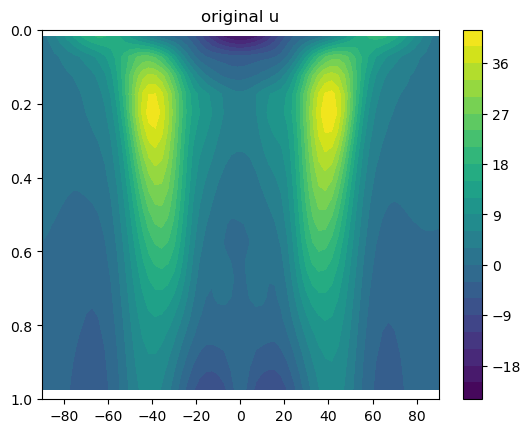

In [2187]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_w_zy.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original u")

(800, 1280)


Text(0.5, 1.0, 'test from EOF and PC back to u')

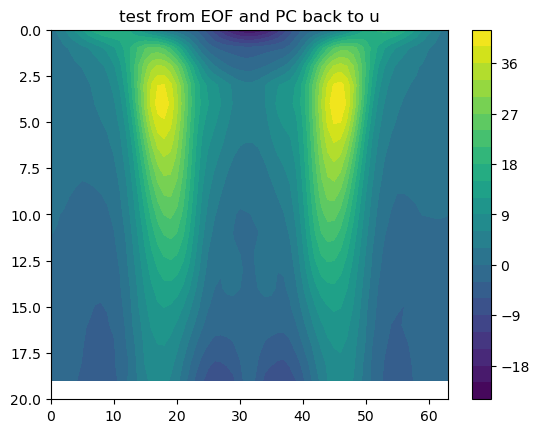

In [2188]:
print(np.shape((single_EOF.EOF.T.dot(single_EOF.PC)).T))
test = np.reshape((single_EOF.EOF.T.dot(single_EOF.PC)).T, (check_days_length, 20*64))
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
plt.figure()
CS = plt.contourf(test_final, levels=21)
plt.colorbar(CS)
plt.ylim([20,0])
plt.title("test from EOF and PC back to u")

# plot original u different PR

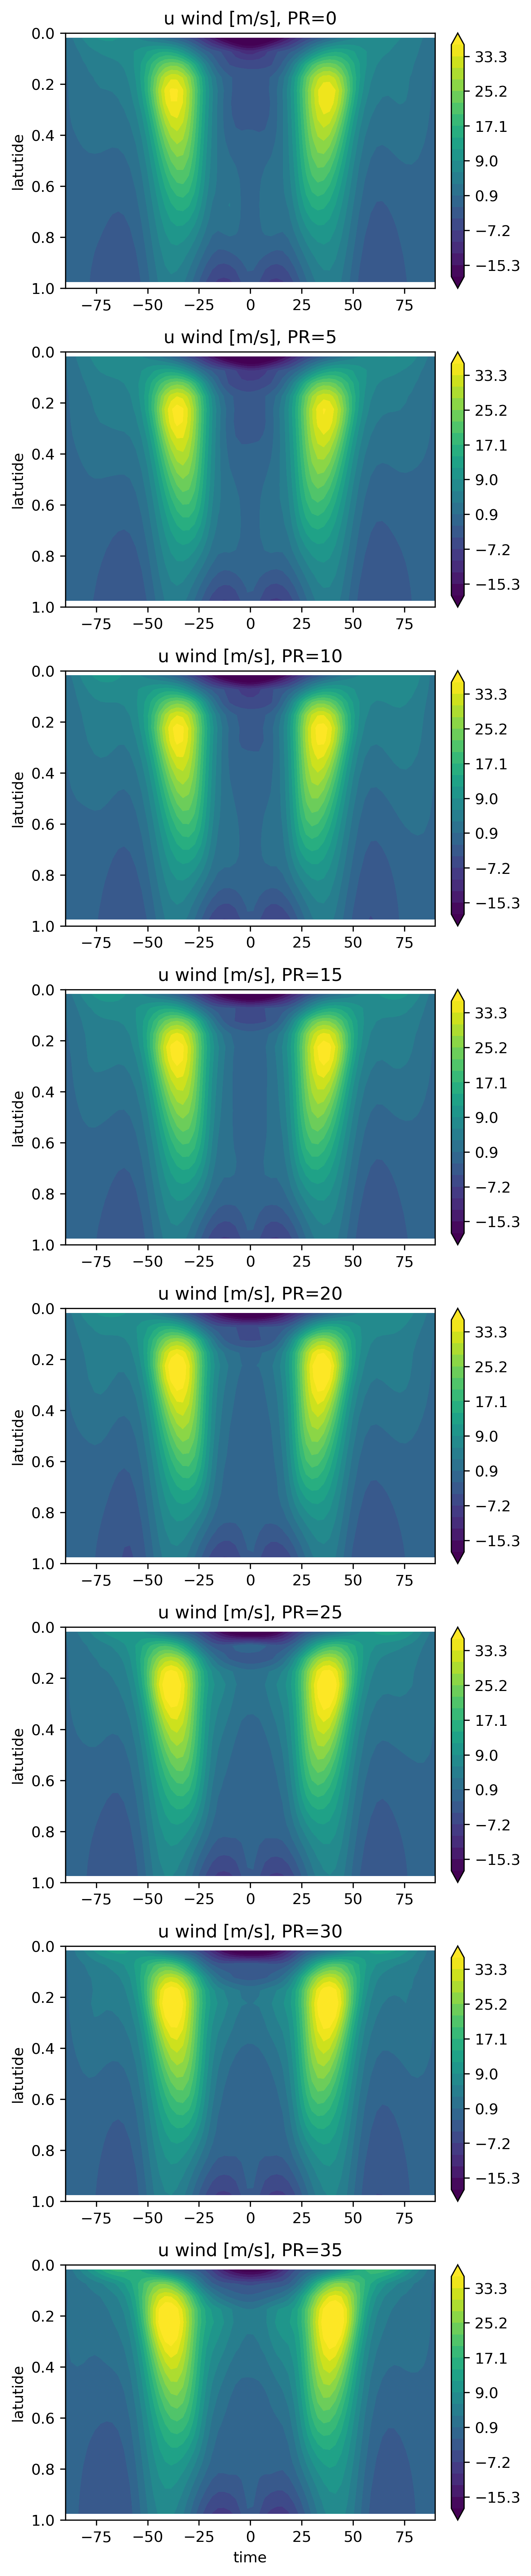

In [2189]:
pr_start = 0
pr_leap = 5
pr_to = 40

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
if do_check_u:
    # plt.savefig("check_U_equilibrium.png", dpi=600., bbox_inches='tight')
    fig.tight_layout()
    plt.show()



# Plot different PR latitude profile u

In [2190]:
cy

array([6.12323400e-17, 4.98458857e-02, 9.95678466e-02, 1.49042266e-01,
       1.98146143e-01, 2.46757398e-01, 2.94755174e-01, 3.42020143e-01,
       3.88434796e-01, 4.33883739e-01, 4.78253979e-01, 5.21435203e-01,
       5.63320058e-01, 6.03804410e-01, 6.42787610e-01, 6.80172738e-01,
       7.15866849e-01, 7.49781203e-01, 7.81831482e-01, 8.11938006e-01,
       8.40025923e-01, 8.66025404e-01, 8.89871809e-01, 9.11505852e-01,
       9.30873749e-01, 9.47927346e-01, 9.62624247e-01, 9.74927912e-01,
       9.84807753e-01, 9.92239207e-01, 9.97203797e-01, 9.99689182e-01,
       9.99689182e-01, 9.97203797e-01, 9.92239207e-01, 9.84807753e-01,
       9.74927912e-01, 9.62624247e-01, 9.47927346e-01, 9.30873749e-01,
       9.11505852e-01, 8.89871809e-01, 8.66025404e-01, 8.40025923e-01,
       8.11938006e-01, 7.81831482e-01, 7.49781203e-01, 7.15866849e-01,
       6.80172738e-01, 6.42787610e-01, 6.03804410e-01, 5.63320058e-01,
       5.21435203e-01, 4.78253979e-01, 4.33883739e-01, 3.88434796e-01,
      

Northern Hemisphere
PR: 0 ,maximum [z index, y index]: 4 12
PR: 5 ,maximum [z index, y index]: 4 12
PR: 10 ,maximum [z index, y index]: 4 11
PR: 15 ,maximum [z index, y index]: 4 12
PR: 20 ,maximum [z index, y index]: 4 12
PR: 25 ,maximum [z index, y index]: 4 12
PR: 30 ,maximum [z index, y index]: 4 12
PR: 35 ,maximum [z index, y index]: 4 13


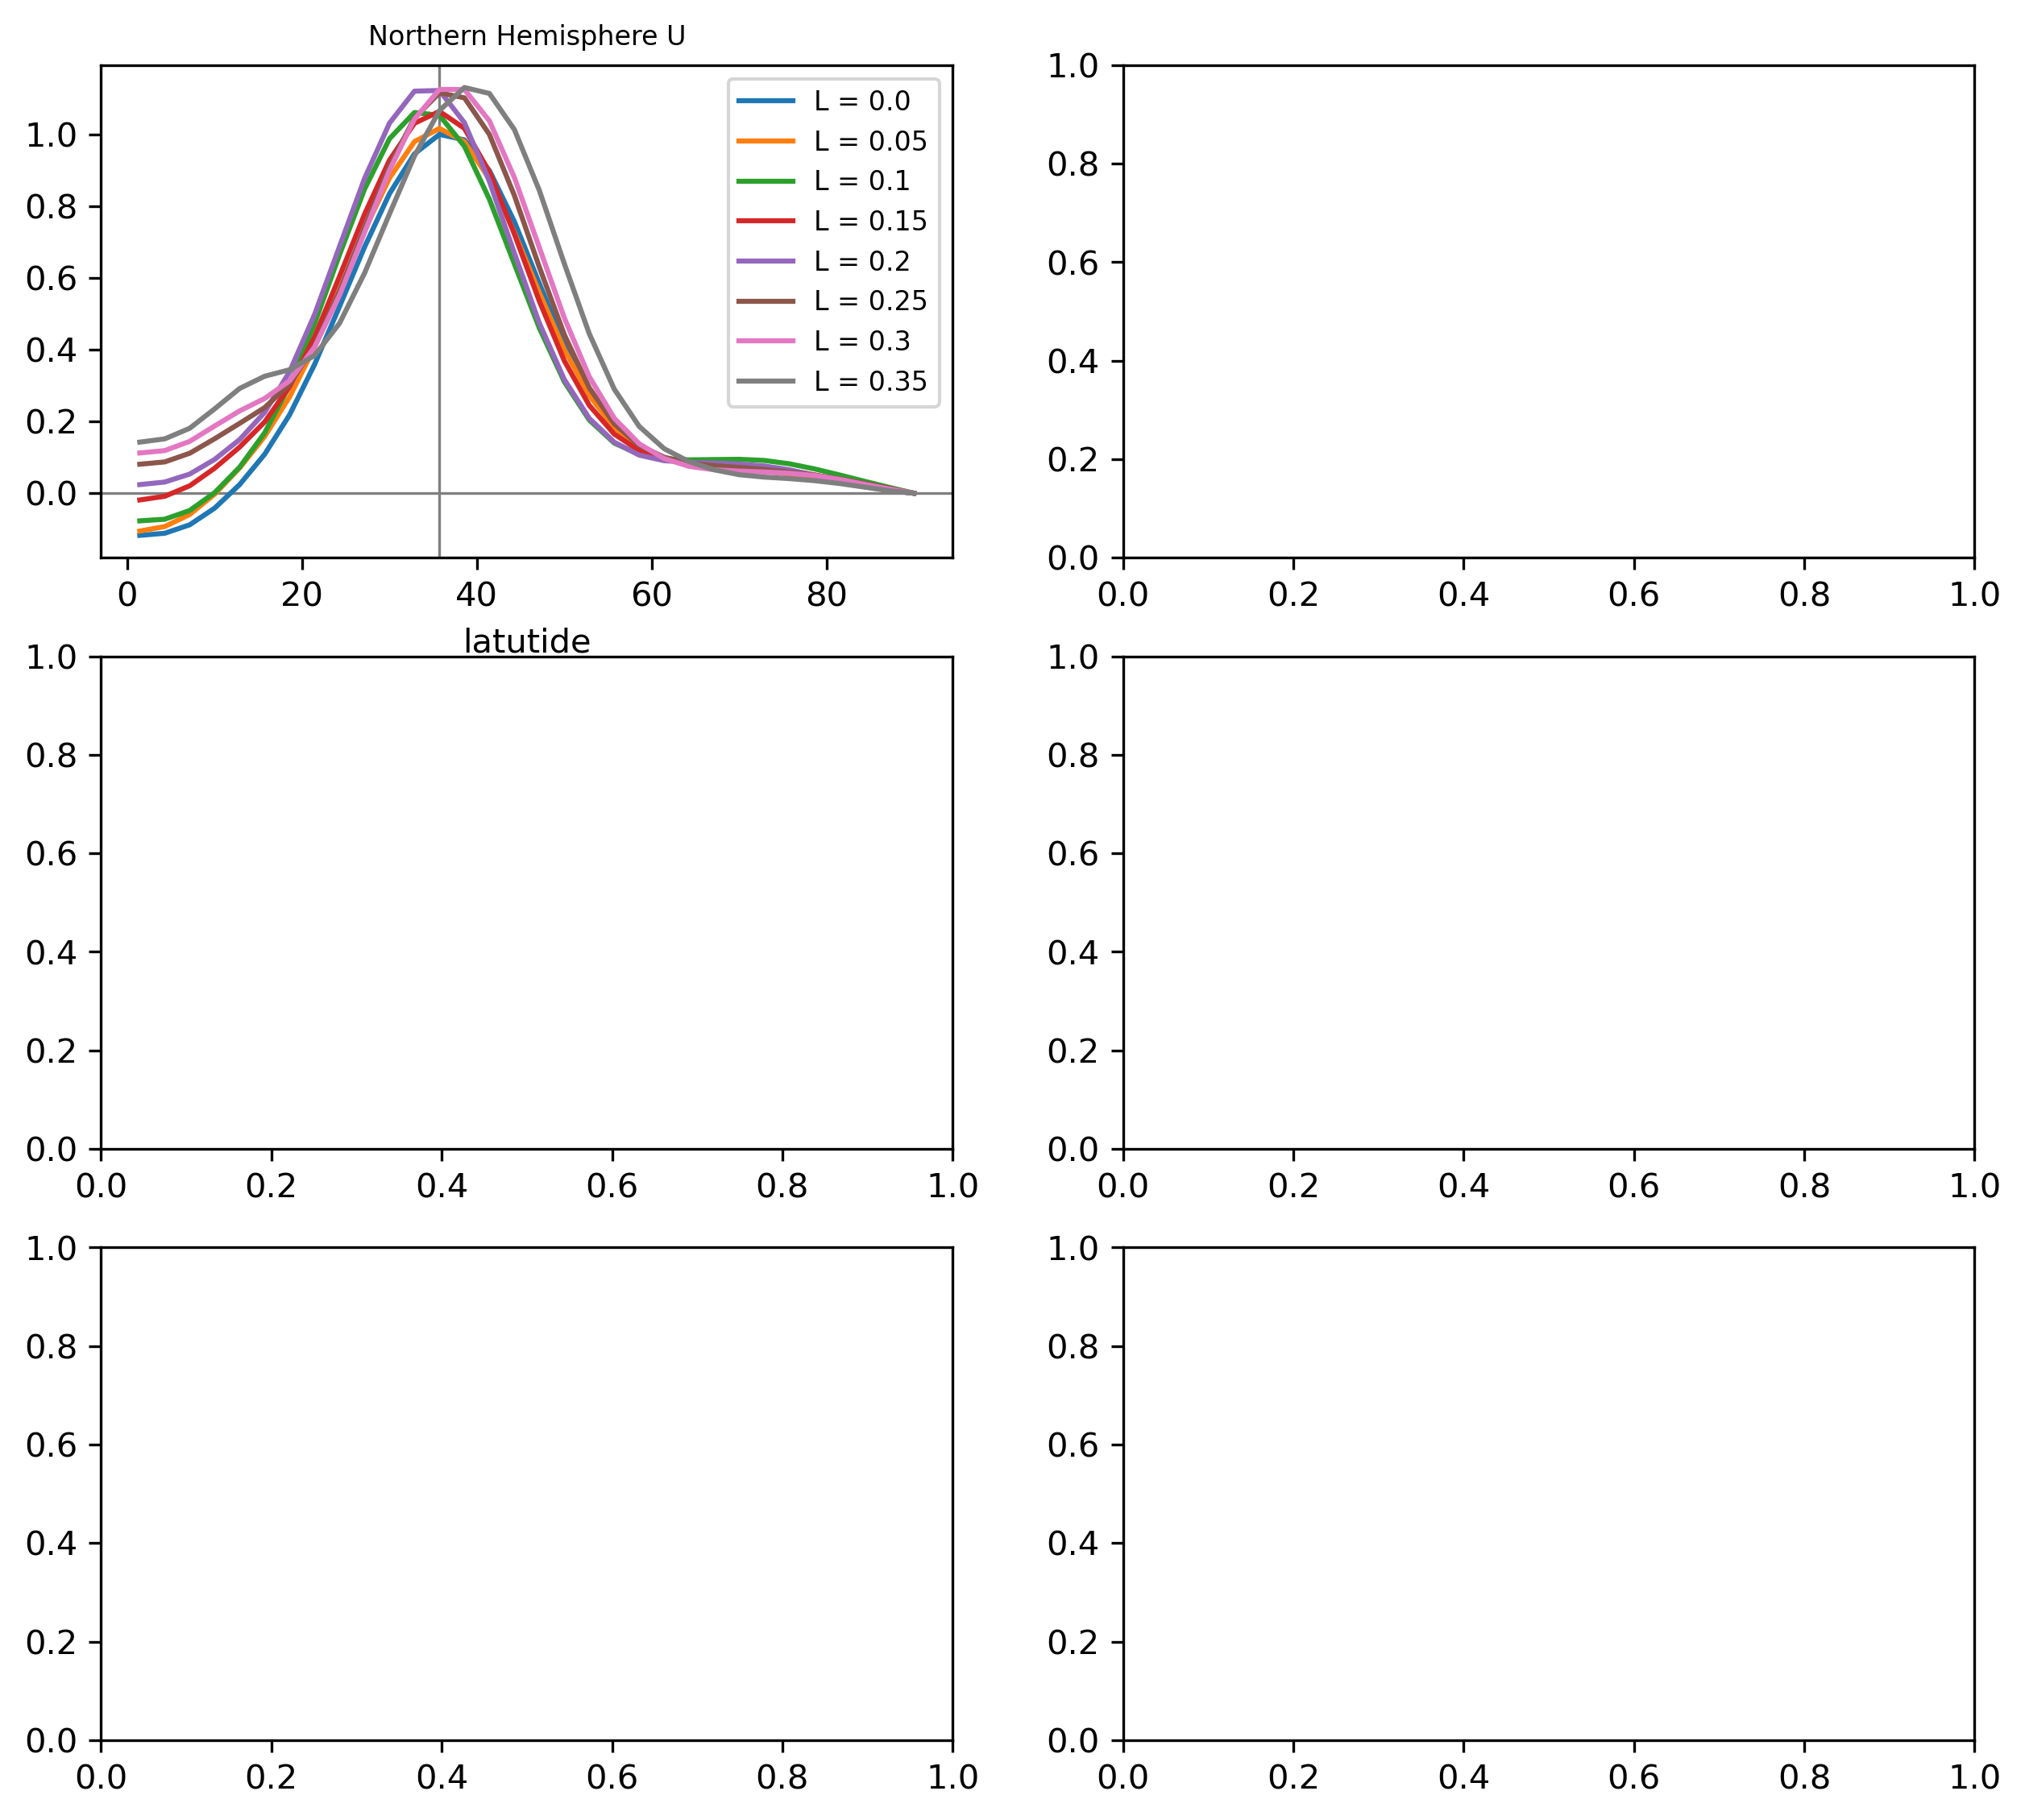

In [2191]:
import matplotlib.colors as colors
import matplotlib as mpl

pr_start = 0
pr_leap = 5
pr_to = 40

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

do_check_north_jet = True
do_check_south_jet = False
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    
    if do_check_north_jet:
        u_north_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_north_half[:,:,i,:] = u[:,:,i+32,:] * cy[i+32]**0.5
        u_zy = np.nanmean(u_north_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        pr_north_idx_y.append(j)
        pr_north_idx_z.append(k)
        # pr_idx_z_y[a,1] = j

        """
        # Becasue the grid is too coarse to identify the location of biggest u wind,
        # it would calculate the index of the biggest five u wind in the below code block.
        """
        if do_check_biggest_n_U:
            # Step 1. Do interpolation, increasing resolution third times
            interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
            yys          = np.linspace(0, 90, 32*interpolation_times)
            sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)
            
            Y, Z = np.meshgrid(yys, sigma_mean2s)
            
            u_zy_thin = interp_spline(sigma_mean2s, yys)
            # Step 2. Find the biggest n U wind
            small_idx = np.dstack(np.unravel_index(np.argsort(u_zy_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)
            biggest_n_U_z[a,:] = small_idx[0,-n:,0]
            biggest_n_U_y[a,:] = small_idx[0,-n:,1]
            
        ############################################################################
        ### plot ###
        if pr == 0:
            print("Northern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[32+j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[32:], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Northern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")
        
    if do_check_south_jet:
        u_south_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_south_half[:,:,i,:] = u[:,:,i,:] * cy[i]**0.5
        u_zy = np.nanmean(u_south_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        if pr == 0:
            print("Southern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[:32], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Southern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")

    a += 1
# plt.legend()
ax[0,0].legend(prop={'size': 8})
plt.show()

In [2192]:
print(biggest_n_U_z[0,:])
print(biggest_n_U_y[0,:])

[50. 49. 48. 46. 46. 50. 48. 50. 49. 47. 47. 49. 48. 48. 49. 47. 47. 49.
 48. 48.]
[128. 127. 132. 130. 129. 130. 127. 129. 131. 131. 128. 128. 131. 128.
 130. 130. 129. 129. 130. 129.]


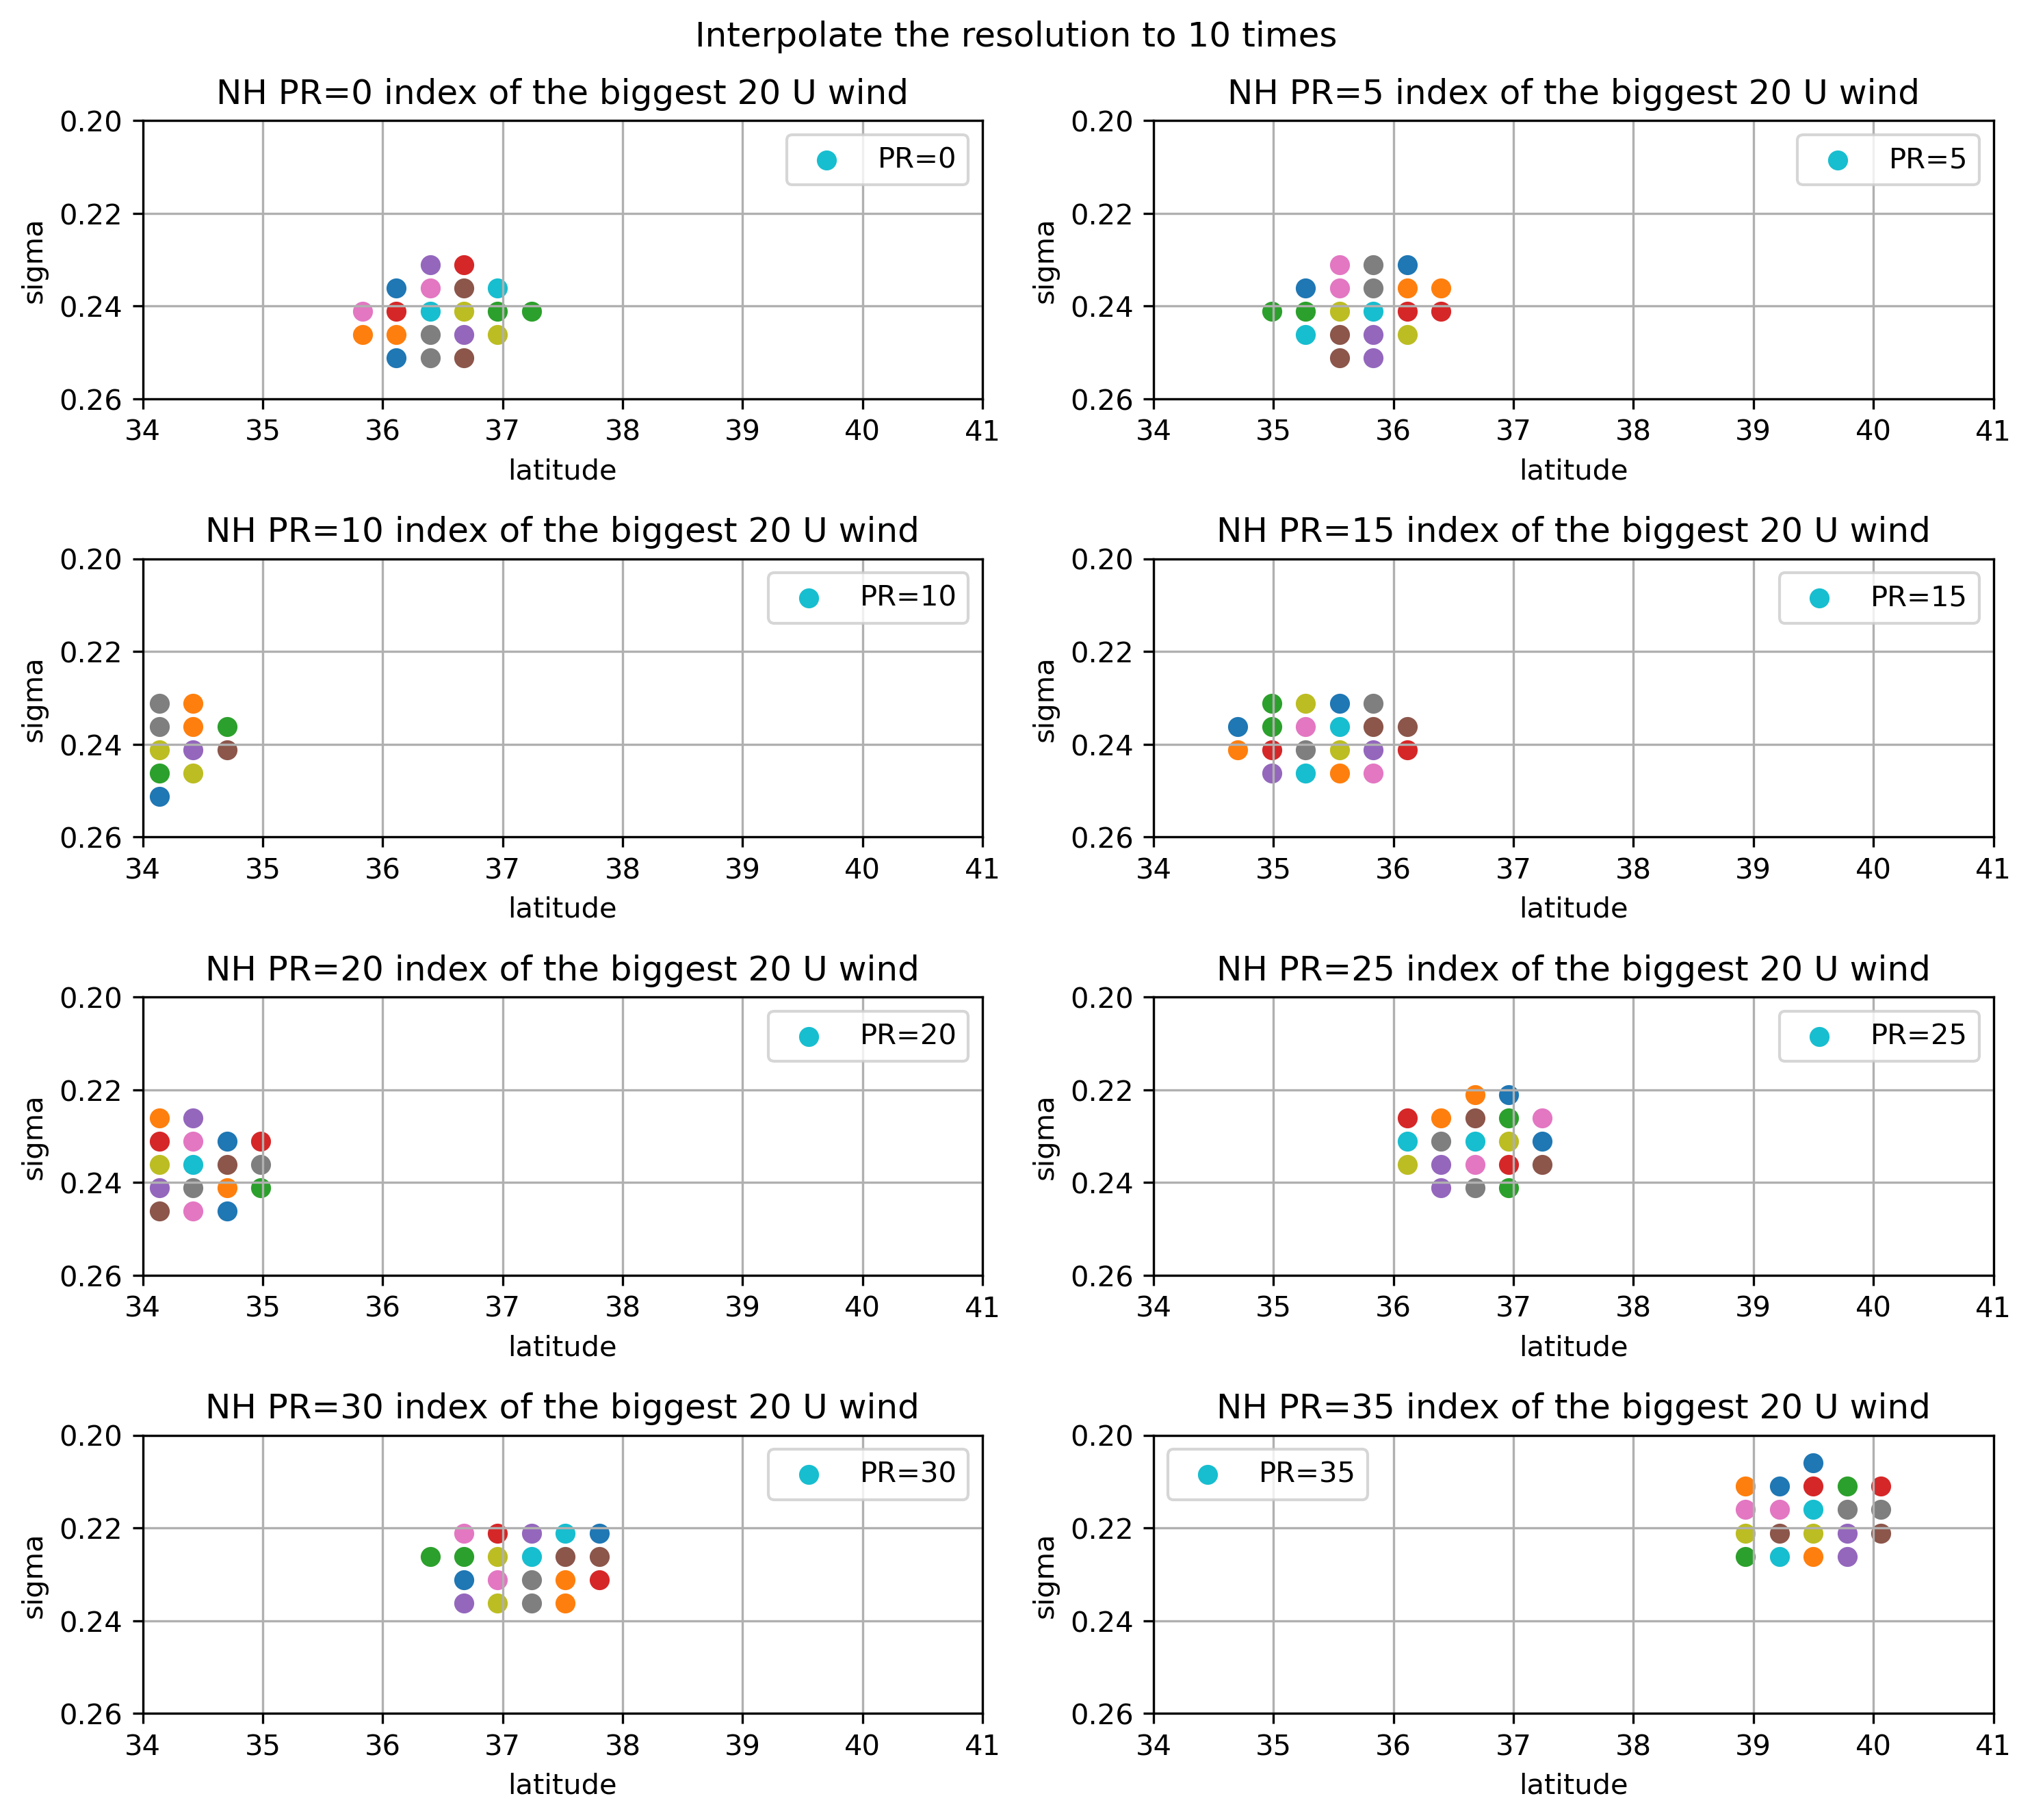

In [2193]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9), dpi=300.)
ax = ax.ravel()
a = 0
# b = 0
y_north = np.linspace(0,90,32*interpolation_times) 
z_north = np.linspace(0, 1,20*interpolation_times) 

for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    for i in range(n):
        if i == int(n-1):
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])], label=f"PR={pr}")
        else:
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])])
            
    ax[a].set_title(f"NH PR={pr} "+f"index of the biggest {n} U wind")
    ax[a].set_ylim([0.26,0.20])
    ax[a].set_xlim([34,41])
    ax[a].set_ylabel("sigma")
    ax[a].set_xlabel("latitude")
    ax[a].legend()
    ax[a].grid()
    a += 1
plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()

# plt.savefig("check_U_index.png", dpi=300., bbox_inches='tight')
plt.show()


In [2194]:
biggest_n_U_y[0,:]

array([128., 127., 132., 130., 129., 130., 127., 129., 131., 131., 128.,
       128., 131., 128., 130., 130., 129., 129., 130., 129.])

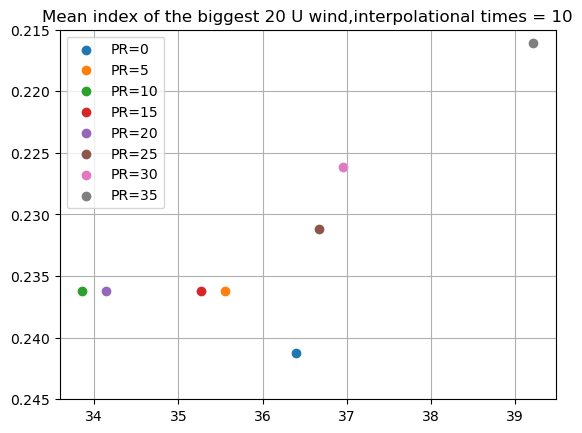

In [2195]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    # print(pr)
    plt.scatter(y_north[int(np.nanmean(biggest_n_U_y[a,:]))], z_north[int(np.nanmean(biggest_n_U_z[a,:]))], label=f"PR={pr}")
    a+=1
plt.ylim([0.245,0.215])
plt.legend()
plt.title(f"Mean index of the biggest {n} U wind,"+f"interpolational times = {interpolation_times}") 
plt.grid()
# plt.savefig("check_mean_U_index.png", dpi=300., bbox_inches='tight')
plt.show()

# Interplotation

In [2196]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [2197]:
sigma_onlyz

array([0.01839397, 0.07357589, 0.12415931, 0.17440211, 0.22453579,
       0.27462053, 0.32467908, 0.37472195, 0.42475472, 0.47478057,
       0.52480149, 0.57481877, 0.62483328, 0.67484563, 0.72485628,
       0.77486556, 0.82487371, 0.87488093, 0.92488737, 0.97489315])

In [2240]:
y[32:]

[]

In [2199]:
u_zy.shape

(20, 32)

In [2200]:
interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
yys          = np.linspace(0,90,64)
sigma_mean2s = np.linspace(0,1,40)

Y, Z = np.meshgrid(yys, sigma_mean2s)

u_zy_thin = interp_spline(sigma_mean2s, yys)
# for i in range(yys.shape[0]):
#     zs[i]=f(yys[i],sigma_mean2s[i])

In [2201]:
u_zy_thin.shape

(40, 64)

(1.0, 0.0)

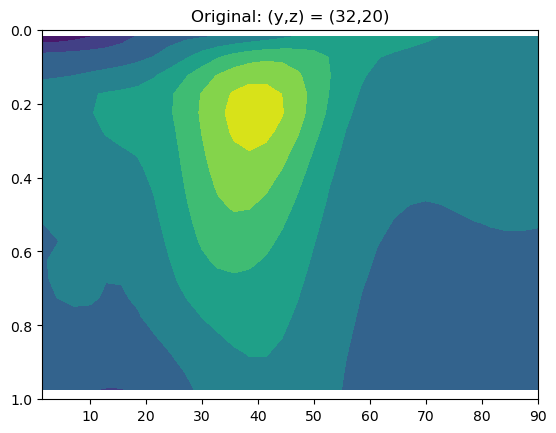

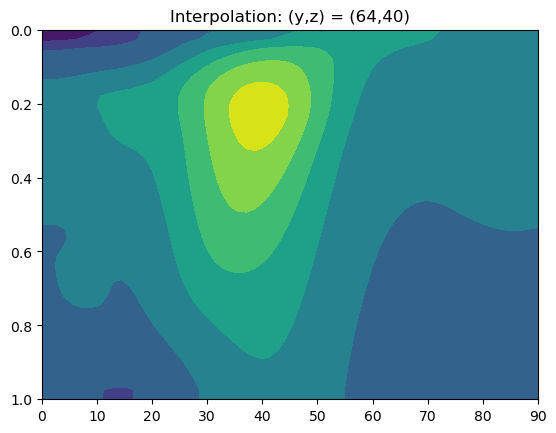

In [2202]:
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:], u_zy)
plt.title("Original: (y,z) = (32,20)")
plt.ylim([1,0])

plt.figure()
plt.title("Interpolation: (y,z) = (64,40)")
plt.contourf(Y, Z, u_zy_thin)
plt.ylim([1,0])

# Calculate error bar of the interpolation

In [2203]:
# Step 1. cut day 200th - 1000th data into 4 files, which are (200~400), (400~600), (600~800), (800~1000)
# Step 2. 4 files output 4 points, then plot error bar of them

In [2235]:
def bootstrap(data, total_times, each_time):
    sample_mean = []
    CI_low      = []
    CI_high     = []
    
    for i in range(total_times):
          y   = random.sample(data.tolist(), each_time) # randomly select each_time
          avg = np.mean(y)
          sample_mean.append(avg)
          CI_low_tmp, CI_high_tmp = st.t.interval(confidence=0.95, 
                                                  df=len(data)-1, 
                                                  loc=np.mean(data),  
                                                  scale=st.sem(data))
            
          CI_low.append(CI_low_tmp)
          CI_high.append(CI_high_tmp)

    CI_low_mean  = np.nanmean(CI_low)
    CI_high_mean = np.nanmean(CI_high)
    return sample_mean, CI_low_mean, CI_high_mean

In [2239]:
np.shape(y)

(4, 64)

8
1.809042061471618
()


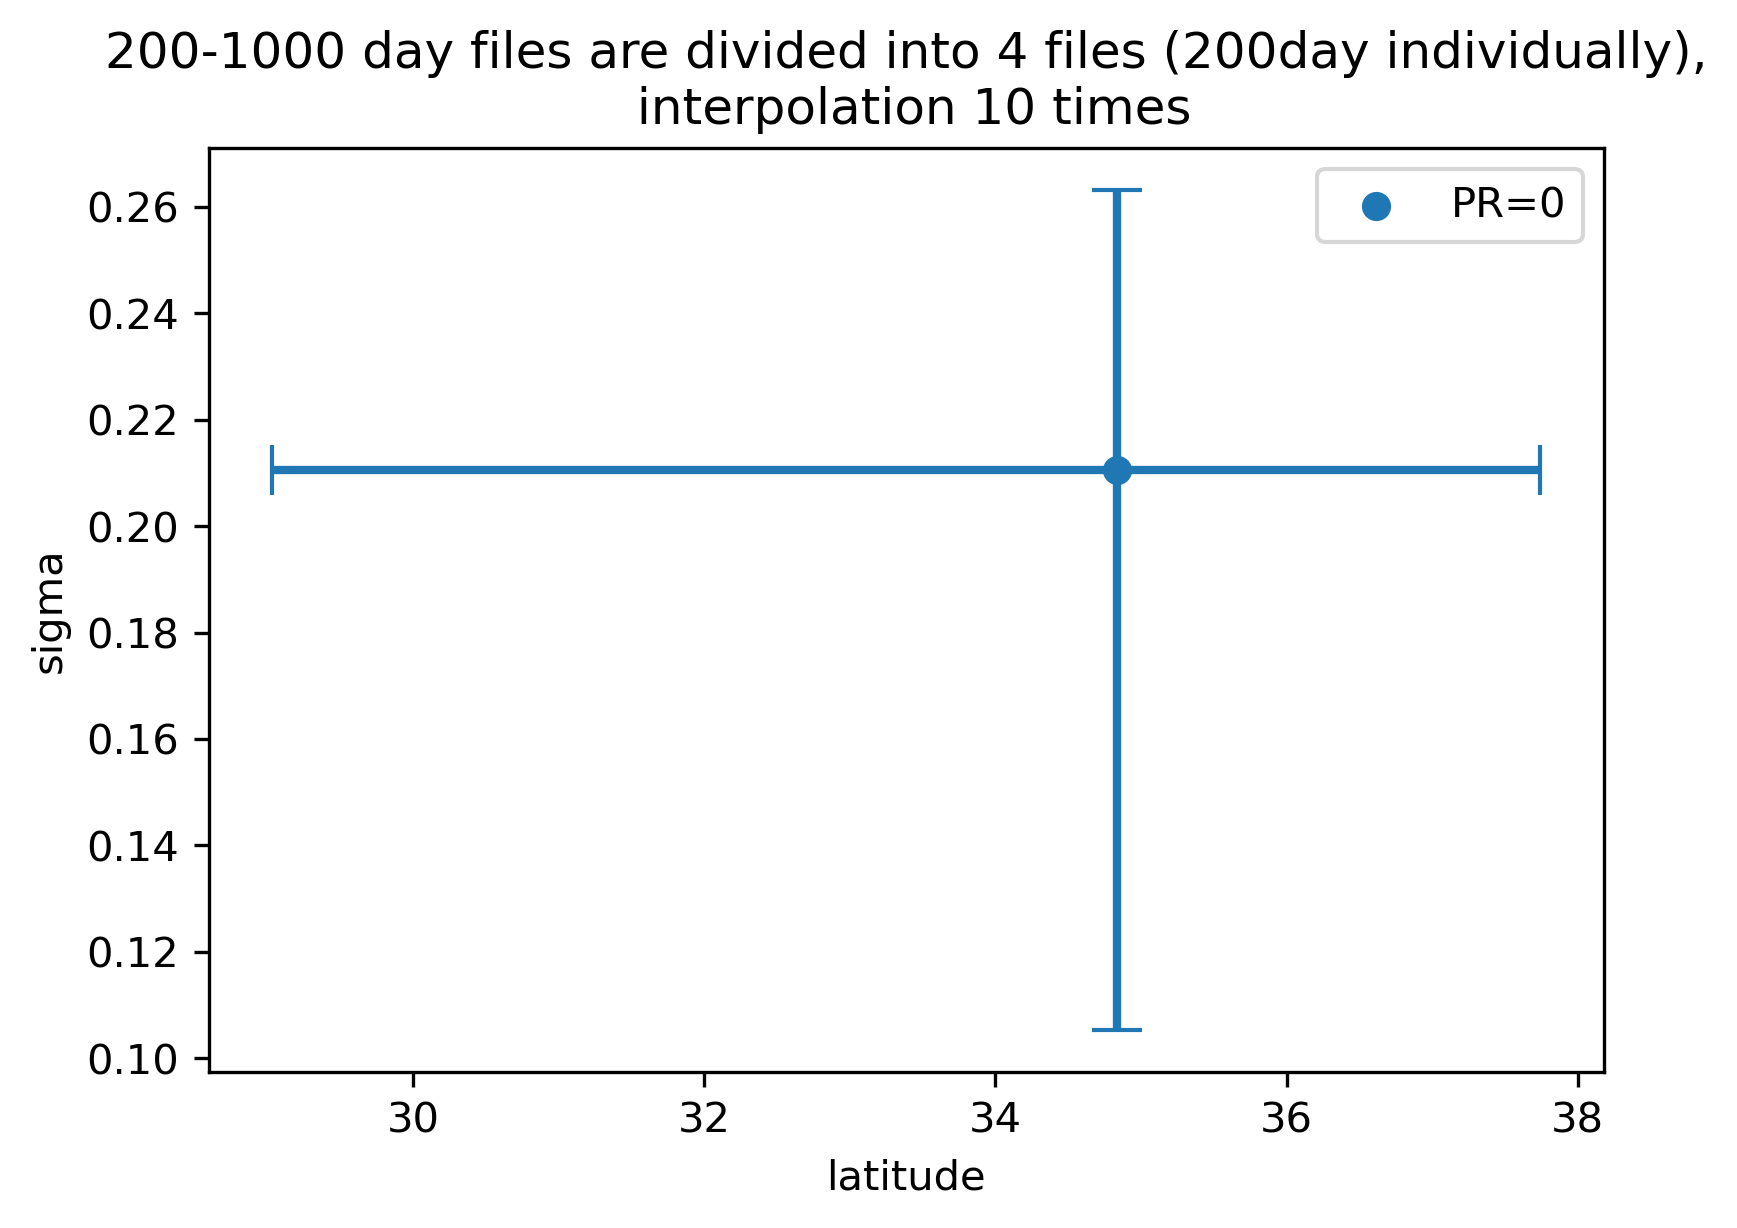

In [2245]:
pr_start = 0
pr_leap = 5
pr_to = 5

### fig
y = np.linspace(-90, 90, 64)
yy, tt = np.meshgrid(y,time)
a      = int(0)
# fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
fig   = plt.figure(1,figsize=(6,4), dpi=300.)

#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)


u = np.zeros((((800, 20, 64, 128))))


do_check_u_error_bar = True

# y_north_original = np.linspace(0,90,32) 
# z_north_original = np.linspace(0, 1,20) 

a = 0
# b = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # print(u_ini.shape)
    b = 0
    for k in range(total_file):
        if do_check_u_error_bar:
            # # if k ==0:
            # u[k,0:100,:,:,:]   = u_ini[b,:,:,:,:] # (8, 100, 20, 64, 128)
            # u[k,100:200,:,:,:] = u_ini[b+1,:,:,:,:]
            # b += 2
            if k ==0:
                u[0:100,:,:,:]           = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]

    # Step 1. given 
    u_all_mean = np.nanmean(u, axis=(0,3))

    # Step 1. Do interpolation, increasing resolution ten times
    interpolation_times = 1
    interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_all_mean[:,32:])
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
    
    Y, Z = np.meshgrid(yys, sigma_mean2s)
    
    u_all_mean_thin = interp_spline(sigma_mean2s, yys)
    
    # Step 2. Find the biggest n U wind
    small_idx = np.dstack(np.unravel_index(np.argsort(u_all_mean_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)

    # Step 3. Do bootstrap
    u_BS_mean, u_BS_CI_low, u_BS_CI_high = bootstrap(u_all_mean_thin, 1000, 4)
    print(u_BS_CI_low)
    print(np.shape(u_BS_CI_low))
    
    # Step 4. Find the biggest n U wind
    n = 20
    biggest_n_U_z_errorbar = np.zeros(((total_file, 4, n)))
    biggest_n_U_y_errorbar = np.zeros(((total_file, 4, n)))
    
    # small_idx = np.dstack(np.unravel_index(np.argsort(u_all_mean[:,32:].ravel()), (np.shape(sigma_mean2)[0], np.shape(y[32:])[0]))) # (1, 20*32, 2)
    
    for i in range(4):
        biggest_n_U_z_errorbar[a,i,:] = small_idx[0,-n:,0]
        biggest_n_U_y_errorbar[a,i,:] = small_idx[0,-n:,1]

        # y_error  = y_north_original[int(np.max(biggest_n_U_y_errorbar[a,i,:]))] - y_north_original[int(np.nanmean(biggest_n_U_y_errorbar[a,i,:]))]
        # y_error2 = y_north_original[int(np.nanmean(biggest_n_U_y_errorbar[a,i,:]))] - y_north_original[int(np.min(biggest_n_U_y_errorbar[a,i,:]))]
        y_error  = yys[int(np.max(biggest_n_U_y_errorbar[a,i,:]) - np.nanmean(biggest_n_U_y_errorbar[a,i,:]))] 
        y_error2 = yys[int(np.nanmean(biggest_n_U_y_errorbar[a,i,:]) - np.min(biggest_n_U_y_errorbar[a,i,:]))] 

        z_error  = sigma_mean2s[int(np.max(biggest_n_U_z_errorbar[a,i,:]) - np.nanmean(biggest_n_U_z_errorbar[a,i,:]))]
        z_error2 = sigma_mean2s[int(np.nanmean(biggest_n_U_z_errorbar[a,i,:]) - np.min(biggest_n_U_z_errorbar[a,i,:]))]
    
    plt.scatter(yys[int(np.nanmean(biggest_n_U_y_errorbar[a,:,:]))], sigma_mean2s[int(np.nanmean(biggest_n_U_z_errorbar[a,:,:]))], label=f"PR={pr}")
    plt.errorbar(yys[int(np.nanmean(biggest_n_U_y_errorbar[a,:,:]))], sigma_mean2s[int(np.nanmean(biggest_n_U_z_errorbar[a,:,:]))], xerr = np.stack([[y_error], [y_error2]]), yerr = np.stack([[z_error],[z_error2]]), fmt='o', elinewidth=2, capsize=6, ms=4) # 

    a += 1
# plt.ylim([0.26,0.2])
plt.title("200-1000 day files are divided into 4 files (200day individually),\n interpolation 10 times")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.legend()
plt.show()



                

In [2205]:
from scipy.stats import bootstrap

In [2206]:
np.shape(u_all_mean)

(20, 64)

In [2207]:
np.shape(u_all_mean.flatten())

(1280,)

In [2259]:
res = bootstrap((u_all_mean,), 
           np.std, 
           confidence_level=0.95, 
           n_resamples = 500,
           vectorized  = True
           )
plt.figure()
plt.hist(res.bootstrap_distribution)
conf_interval = res.confidence_interval
# print(conf_interval)
# plt.axvline(conf_interval[0,:], color="red")
# plt.axvline(conf_interval[1,:], color="red")


TypeError: bootstrap() got an unexpected keyword argument 'confidence_level'

In [2209]:
print(np.shape(res.bootstrap_distribution))


(64, 500)


(array([ 5.,  4.,  3.,  9., 21.,  5.,  3.,  4.,  3.,  7.]),
 array([ 1.44361989,  5.8772361 , 10.31085231, 14.74446852, 19.17808473,
        23.61170094, 28.04531715, 32.47893336, 36.91254957, 41.34616578,
        45.77978199]),
 <BarContainer object of 10 artists>)

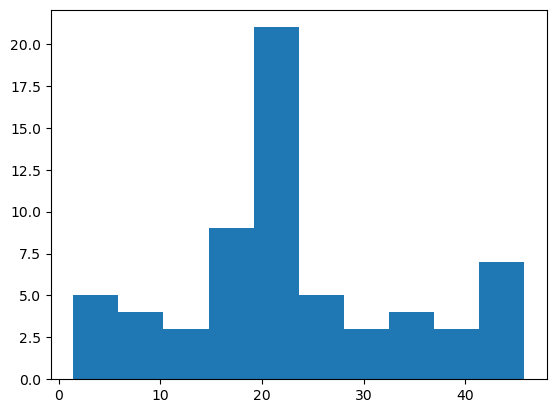

In [2210]:
plt.figure()
plt.hist(np.nanmean(res.bootstrap_distribution[:,:],axis=1))

In [2211]:
# print(np.shape(conf_interval))
# print((conf_interval))
CI = np.percentile(u_all_mean, [2.5, 97.5], axis=0)
print(np.shape(CI))
print(CI[1])
# print(np.nanmean(conf_interval[0].all()))
# print(np.nanmean(conf_interval[1].all()))

# plt.axvline(np.nanmean(conf_interval[0].all()), color="red")
# plt.axvline(np.nanmean(conf_interval[1].all()), color="red")

(2, 64)
[  4.3439036    9.91841375  15.66363772  21.71071453  28.09082179
  34.68370095  41.27513443  47.49874607  52.8497124   56.95115759
  59.82306042  61.81466556  63.36096215  76.36949428  98.6038793
 124.86422119 146.32879472 158.45980424 159.53659613 150.27128397
 133.30491946 111.8456474   89.30230672  69.41345326  55.23989839
  46.65937025  40.69979752  34.69330975  28.14883623  22.17422744
  18.09417104  16.35324484  16.55122923  18.62277745  23.18468747
  29.93276163  36.52504327  40.72948933  43.79420599  50.13013107
  63.20673711  82.83304529 106.14803577 129.73607453 149.3892195
 161.01154172 162.60172866 152.45161238 131.74465929 105.05220284
  81.85847071  68.27728433  65.88773233  62.684659    58.51018335
  53.34000268  47.29274587  40.62156711  33.69552045  26.89380121
  20.47229477  14.52655722   9.02750098   3.87313426]


In [2248]:
np.shape(u_all_mean)

(20, 64)

2.9463115156474253
6.835967368475636
(1000,)


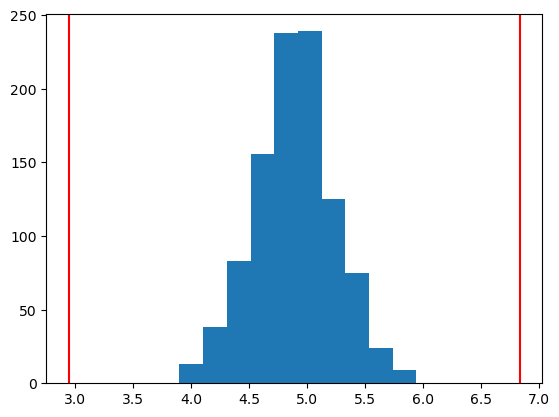

In [2288]:
import numpy as np
import random
import scipy.stats as st 

# x = np.random.normal(loc= 300.0, size=1000)

sample_mean = []
CI_low  = []
CI_high = []
for i in range(1000):
  avg_tmp     = []
  CI_low_tmp  = []
  CI_high_tmp = []
    
  for i in range(20):
      y   = random.sample(u_all_mean[i,:].tolist(), 20) # randomly select 10
      avg_tmp.append(np.mean(y))
      low, high = st.t.interval(confidence=0.95, 
                                              df=len(u_all_mean[i,:])-1, 
                                              loc=np.mean(u_all_mean[i,:]),  
                                              scale=st.sem(u_all_mean[i,:]))
      CI_low_tmp.append(low)
      CI_high_tmp.append(high)
  sample_mean.append(np.nanmean(avg_tmp))
  CI_low.append(np.nanmean(CI_low_tmp))
  CI_high.append(np.nanmean(CI_high_tmp))
# print(y)


CI_low_mean  = np.nanmean(CI_low)
CI_high_mean = np.nanmean(CI_high)
print(CI_low_mean)
print(CI_high_mean)
# print(sample_mean)
print(np.shape(sample_mean))




# print(sample_mean)
# print(CI_low)
# print(np.shape(CI_low))
# print((CI_low))

  # CI = np.percentile(x, [50, 97.5])
    
# print(np.mean(sample_mean))
# print(CI)
plt.figure()
plt.hist(sample_mean)
plt.axvline(CI_low_mean, color="red")
plt.axvline(CI_high_mean, color="red")
# print(x)

In [2304]:
y = random.sample(u_all_mean.tolist(), 20)


(100,)
2.3003545393015146
7.48192434482155


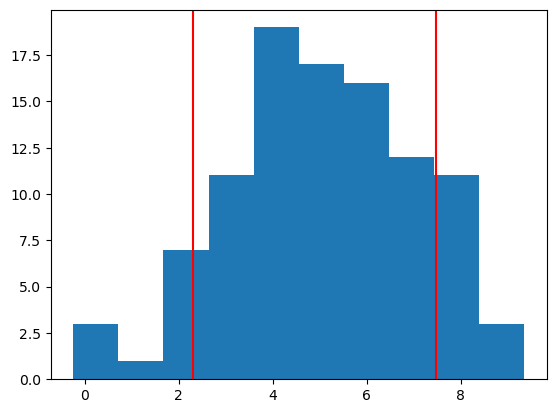

4.891139442061532


(array([ 0.,  9.,  0.,  0.,  0.,  0., 89.,  0.,  0.,  2.]),
 array([4.89113944, 4.89113944, 4.89113944, 4.89113944, 4.89113944,
        4.89113944, 4.89113944, 4.89113944, 4.89113944, 4.89113944,
        4.89113944]),
 <BarContainer object of 10 artists>)

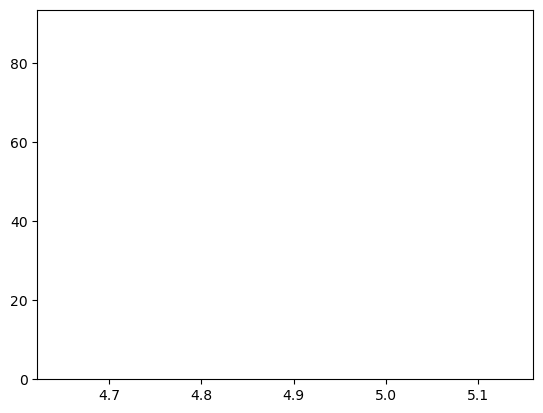

In [2301]:
### old edition
sample_mean = []
CI_low      = []
CI_high     = []

for i in range(100):
      y   = random.sample(u_all_mean.tolist(), 4) # randomly select each_time
      avg = np.mean(y)
      sample_mean.append(avg)
      CI_low_tmp, CI_high_tmp = st.t.interval(confidence=0.95, 
                                              df=len(u_all_mean)-1, 
                                              loc=np.mean(u_all_mean),  
                                              scale=st.sem(u_all_mean))
        
      CI_low.append(CI_low_tmp)
      CI_high.append(CI_high_tmp)
    
CI_low_mean  = np.nanmean(CI_low)
CI_high_mean = np.nanmean(CI_high)
print(np.shape(sample_mean))
print(CI_low_mean)
print(CI_high_mean)
# print(sample_mean)
# print(sample_mean)
plt.figure()
plt.hist(sample_mean)
plt.axvline(CI_low_mean, color="red")
plt.axvline(CI_high_mean, color="red")
# plt.plot(sample_mean)
plt.show()
#######################################################################
import numpy as np
import random

# x = np.random.normal(loc= 300.0, size=1000)
# print(np.mean(x))

sample_mean = []
for i in range(100):
  y = random.sample(u_all_mean.tolist(), 20)
  avg = np.mean(y)
  sample_mean.append(avg)

print(np.mean(sample_mean))
plt.figure()
plt.hist(sample_mean)

In [ ]:
### 01/15 final work
### have done bootstrap function
### need to find the y index and z index using bootstrap method

# Reproduce Nick fig.1 using interpolative U

ValueError: could not broadcast input array from shape (100,20,64,128) into shape (4,200,20,64,128)

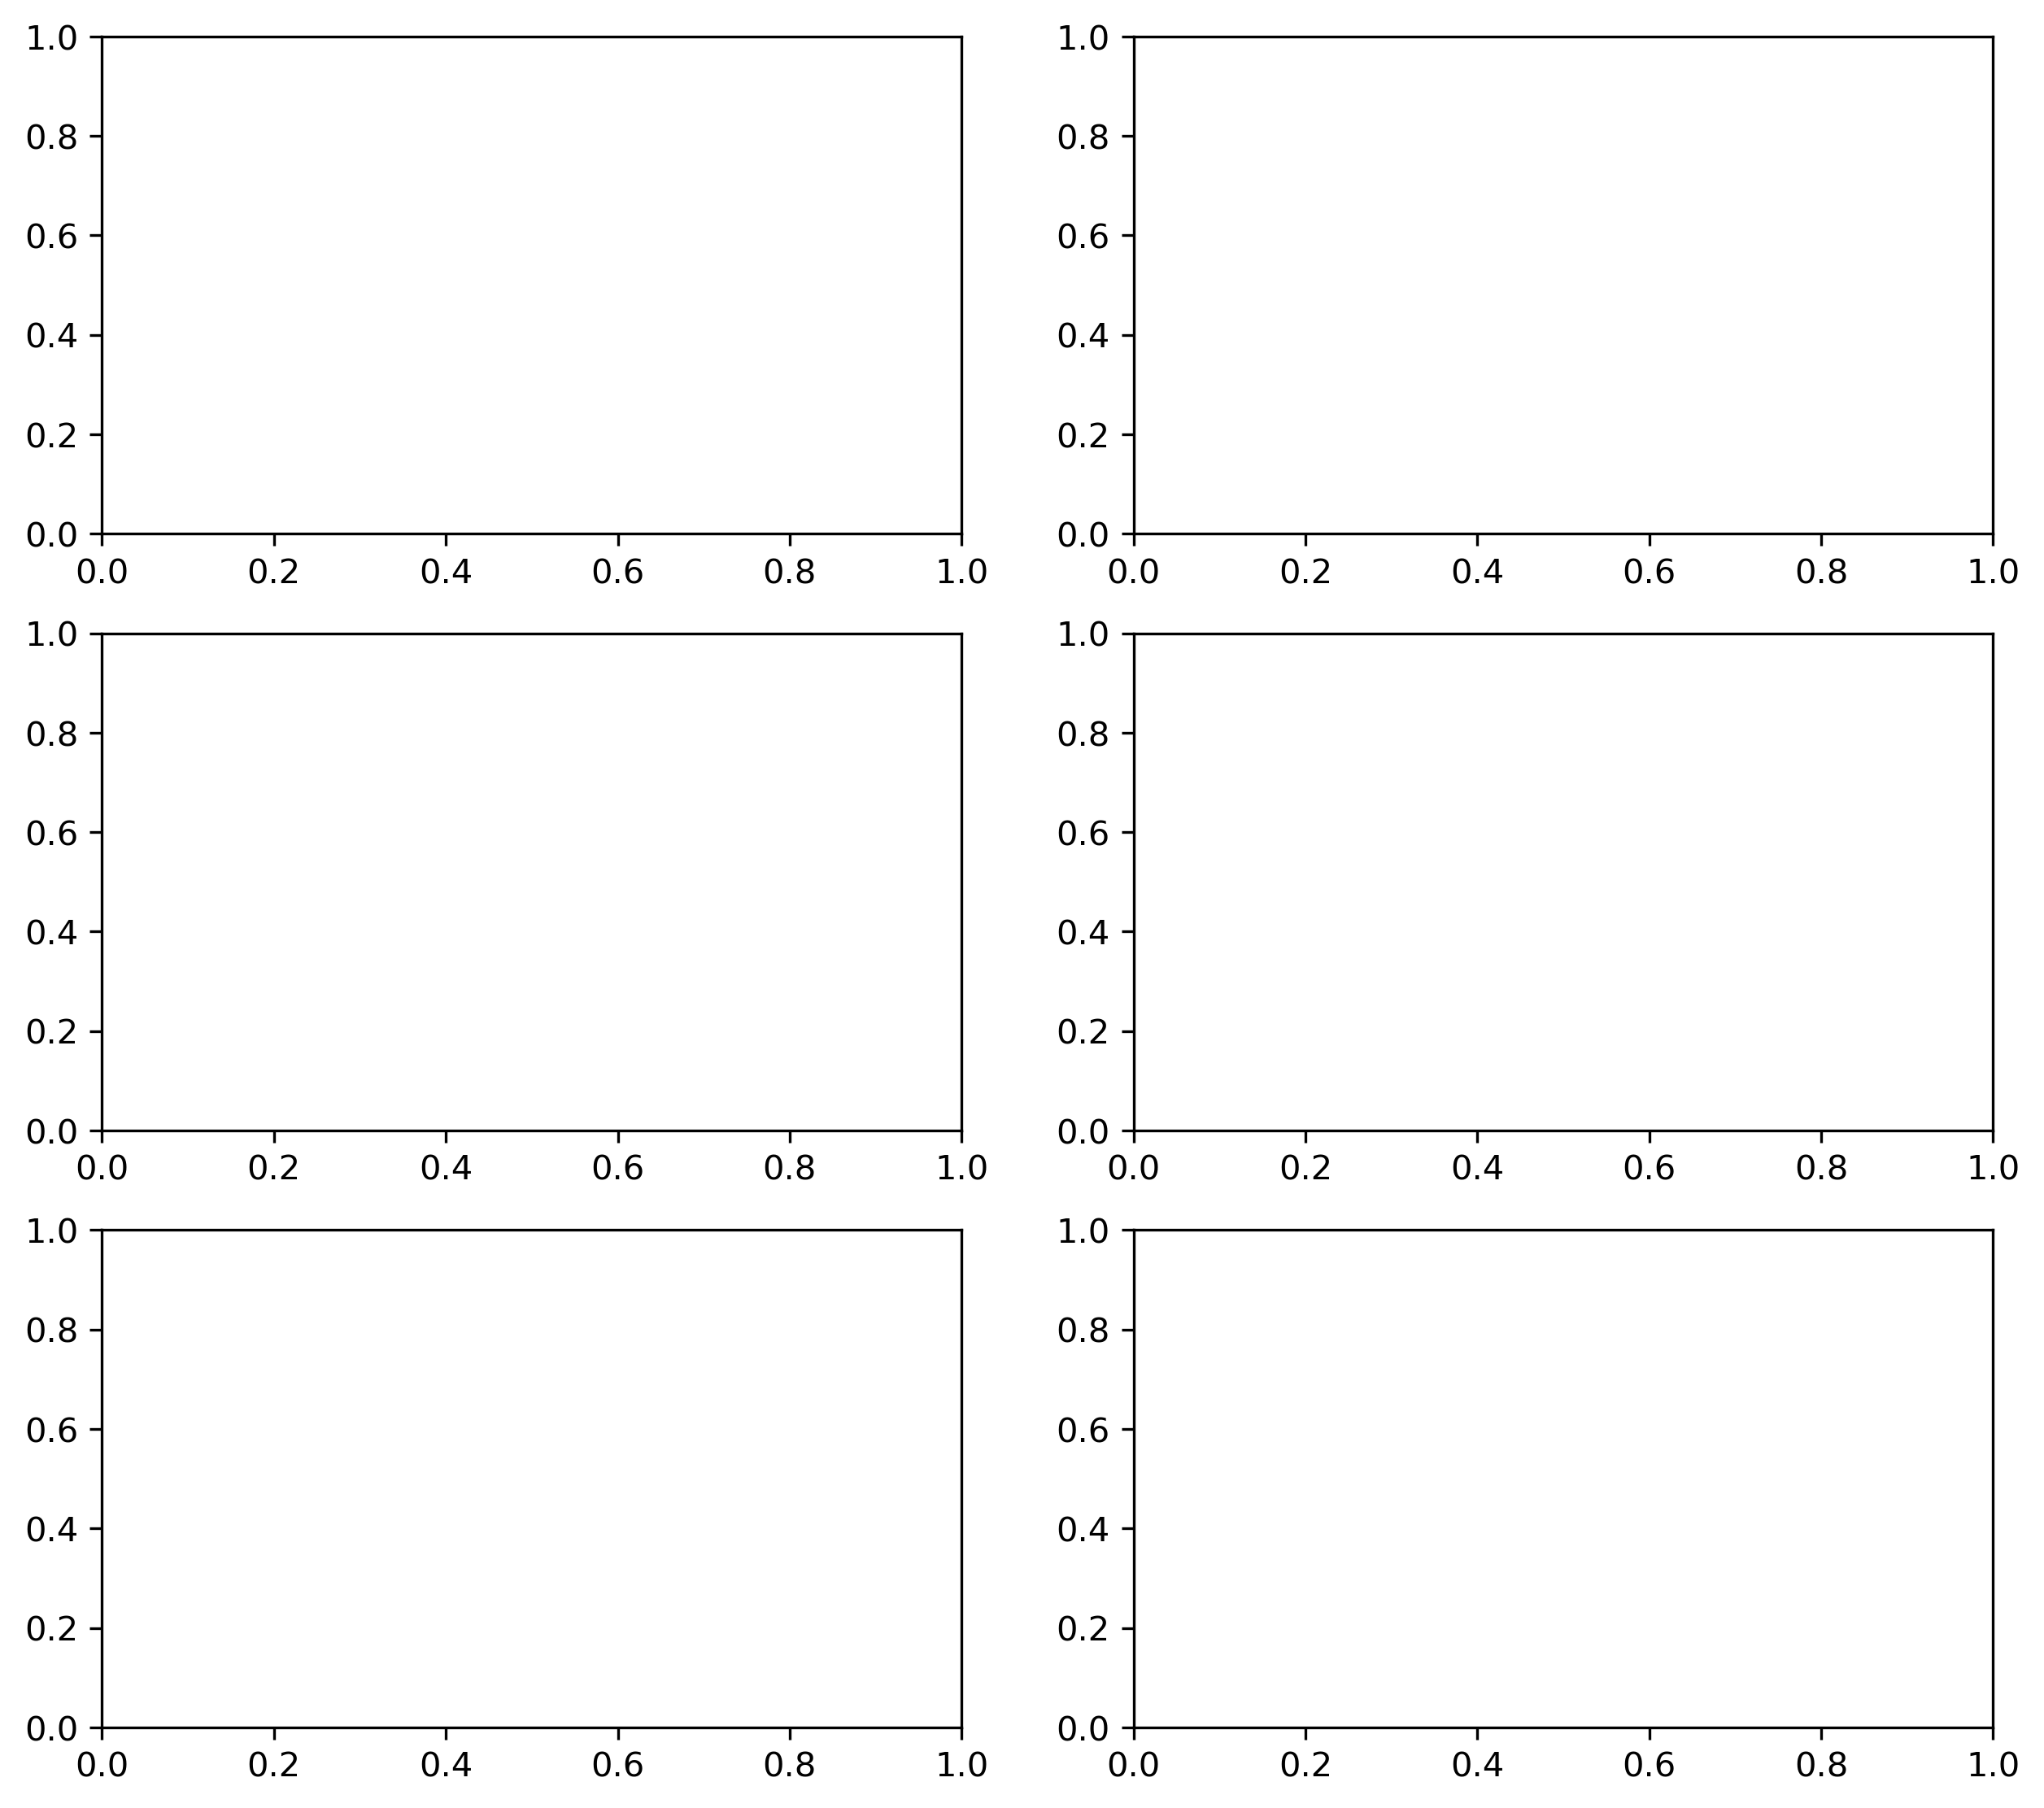

In [2213]:
import matplotlib.colors as colors
import matplotlib as mpl

pr_start = 0
pr_leap = 5
pr_to = 40

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

do_check_north_jet = True
do_check_south_jet = False
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    
    if do_check_north_jet:
        u_north_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_north_half[:,:,i,:] = u[:,:,i+32,:] * cy[i+32]**0.5
        u_zy = np.nanmean(u_north_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        pr_north_idx_y.append(j)
        pr_north_idx_z.append(k)
        # pr_idx_z_y[a,1] = j

        """
        # Becasue the grid is too coarse to identify the location of biggest u wind,
        # it would calculate the index of the biggest five u wind in the below code block.
        """
        if do_check_biggest_n_U:
            # Step 1. Do interpolation, increasing resolution third times
            interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
            yys          = np.linspace(0, 90, 32*interpolation_times)
            sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)
            
            Y, Z = np.meshgrid(yys, sigma_mean2s)
            
            u_zy_thin = interp_spline(sigma_mean2s, yys)
            # Step 2. Find the biggest n U wind
            small_idx = np.dstack(np.unravel_index(np.argsort(u_zy_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)
            biggest_n_U_z[a,:] = small_idx[0,-n:,0]
            biggest_n_U_y[a,:] = small_idx[0,-n:,1]
            
        ############################################################################
        ### plot ###
        if pr == 0:
            print("Northern Hemisphere")
            control = np.nanmax(u_zy_thin[k,:])
            ax[0,0].axvline(x=y[32+j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[32:], u_zy_thin[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Northern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")
        
    # if do_check_south_jet:
    #     u_south_half = np.zeros((((u.shape[0],20,32,128))))
    #     for i in range(32):
    #         u_south_half[:,:,i,:] = u[:,:,i,:] * cy[i]**0.5
    #     u_zy = np.nanmean(u_south_half, axis=(0,3))
    #     idx_max = np.argmax(u_zy)
    #     k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
    #                                                  #            maxumum y: jth index
    #     if pr == 0:
    #         print("Southern Hemisphere")
    #         control = np.nanmax(u_zy[k,:])
    #         ax[0,0].axvline(x=y[j], color='gray', lw=0.8)
    #         ax[0,0].axhline(y=0, color='gray', lw=0.8)
    #     print("PR:",pr,",maximum [z index, y index]:", k,j)
        
    #     ax[0,0].plot(y[:32], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
    #     ax[0,0].set_title("Southern Hemisphere U", fontsize=8)
    #     ax[0,0].set_xlabel("latutide")

    a += 1
# plt.legend()
ax[0,0].legend(prop={'size': 8})
plt.show()